In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline
import datetime as dt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import log_loss, make_scorer, f1_score, recall_score, accuracy_score 
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('ggplot')

## Import the cleaned data set

In [2]:
df = pd.read_csv("cleaned_CA_data.csv")

In [3]:
df = df.drop(columns=['Unnamed: 0'])

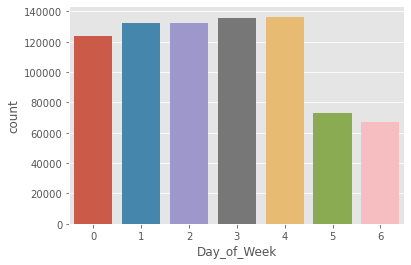

In [4]:
sns.countplot(x="Day_of_Week", data=df)

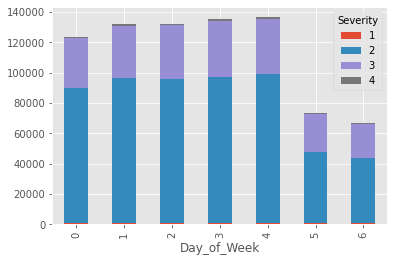

In [5]:
df.groupby(['Day_of_Week','Severity']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

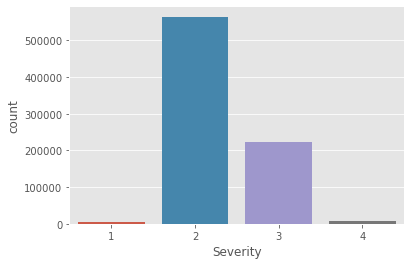

In [6]:
sns.countplot(x="Severity", data=df)

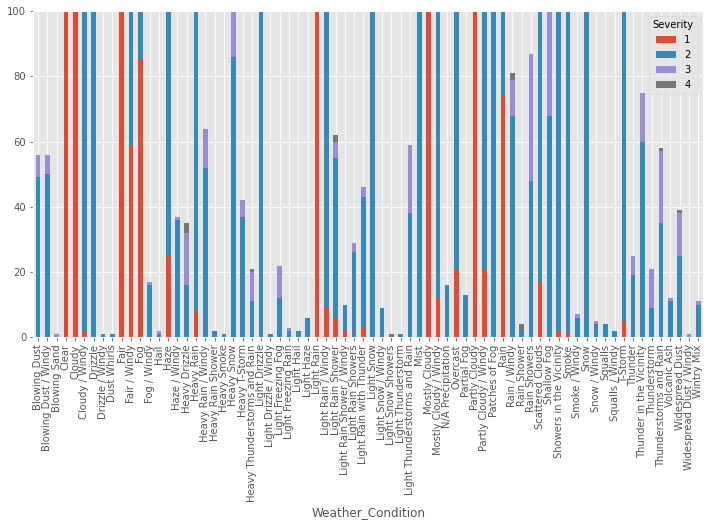

In [7]:
df.groupby(['Weather_Condition','Severity']).size().unstack().plot(kind='bar',stacked=True,
                                                                   figsize=(12,6), ylim=(0,100))
plt.show()

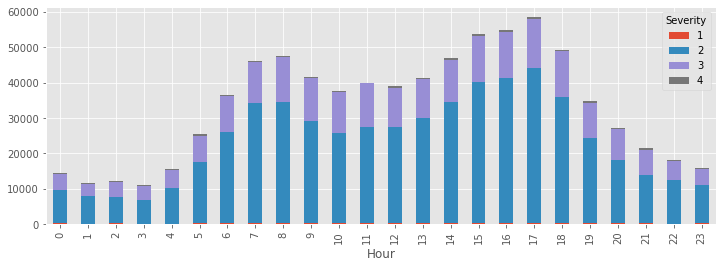

In [8]:
df.groupby(['Hour','Severity']).size().unstack().plot(kind='bar',stacked=True, figsize=(12,4))
plt.show()

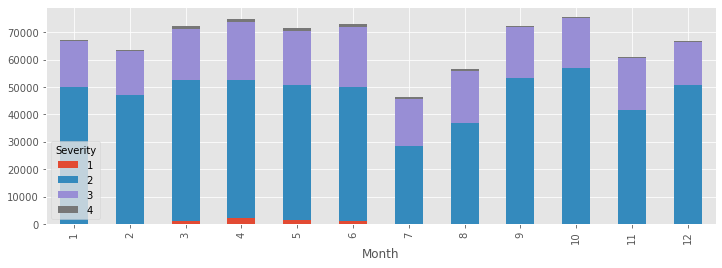

In [9]:
df.groupby(['Month','Severity']).size().unstack().plot(kind='bar',stacked=True, figsize=(12,4))
plt.show()

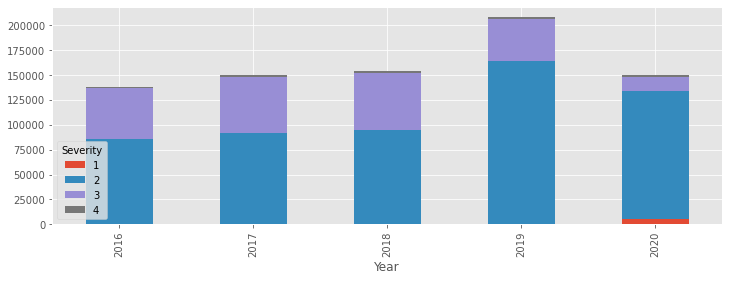

In [80]:
df.groupby(['Year','Severity']).size().unstack().plot(kind='bar',stacked=True, figsize=(12,4))
plt.show()

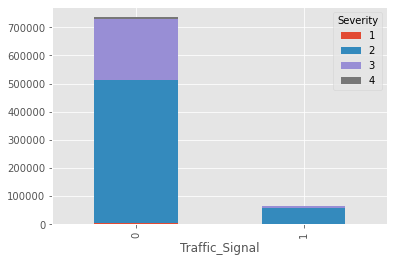

In [11]:
df.groupby(['Traffic_Signal','Severity']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

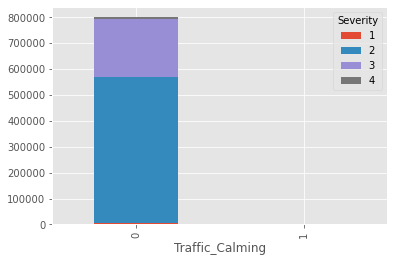

In [12]:
df.groupby(['Traffic_Calming','Severity']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

In [13]:
#plot Severity distribution and print count for each
# df['County'].plot(kind="hist")
county_ct = dict()
for i in df['County'].unique():
#     print('County', i, df[df['County'] == i]['Severity'].count())
    county_ct[i] = df[df['County'] == i]['Severity'].count()

sorted_x = sorted(county_ct.items(), key=lambda kv: kv[1])
sorted_x

'''
Top ounties with the most accident records:
1. LA
2. Alameda
3. Orange
4. San Diego
5. San Bernardino
6. Sacramento
7. Riverside
8. Santa Clara
9. Contra Costa
10. San Mateo
'''

'\nTop ounties with the most accident records:\n1. LA\n2. Alameda\n3. Orange\n4. San Diego\n5. San Bernardino\n6. Sacramento\n7. Riverside\n8. Santa Clara\n9. Contra Costa\n10. San Mateo\n'

### Let's run a Decision Tree Classifier just to see what the results look like:
- Accuracy: 0.858
- What does this mean? Over 560k of the 800k are Severity == 2...

In [14]:
cols = df.columns.tolist()

y_col = 'Severity'
X_col = cols
X_col.remove('Severity')
X_col.remove('Description')
X_col.remove('Street')
X_col.remove('City')
X_col.remove('County')
X_col.remove('Weather_Condition')
X_col.remove('Date')
#Removed columns that have string values. Will need to get_dummies or convert to_numeric in order to use them

X = df[X_col]
y = df[y_col]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=462)

In [16]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

print("Accuracy = {:.3f}".format(np.mean(clf.predict(X_test) == y_test)))

print("My prediction: {}".format(clf.predict(X_test)[0:20]))
print("Actual result: {}".format(y_test[0:20]))

Accuracy = 0.848
My prediction: [2 2 3 2 2 2 3 3 2 3 3 2 2 2 2 2 2 2 2 2]
Actual result: [2 2 3 2 2 2 2 2 3 3 3 2 2 2 2 2 2 2 2 2]


In [17]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=20,
                           max_features='auto',
                           random_state=0)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
# print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

accuracy = 0.8511796189038864


In [18]:
# f1 score
print("F1 score:", f1_score(y_test, pred, average='weighted'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='weighted'))

F1 score: 0.8455754843299678
Recall score: 0.8511796189038864


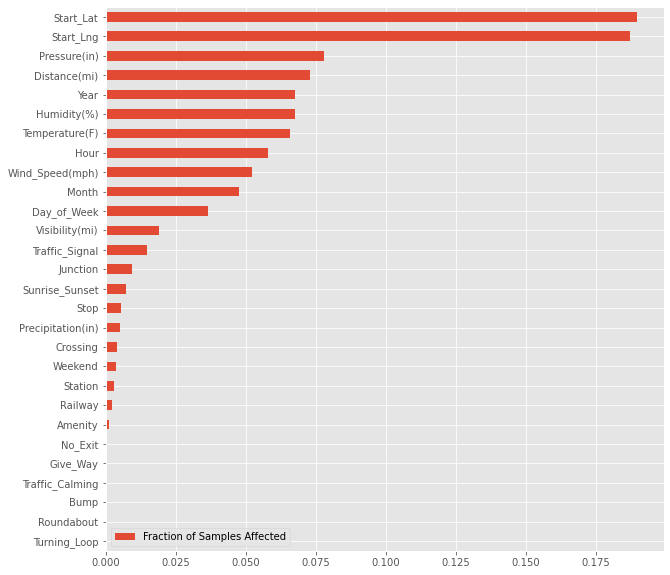

In [19]:
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', figsize=(10,10))

## Turn `Weather_Condition` and `Severity` into binary features
- Separate Weather Conditions into "good" and "bad"
    - Maybe break it down further? "Good", "Okay", and "Bad"?
- Separate Severity into binary -- (1 and 2) and (3 and 4)

In [20]:
pd.set_option('display.max_rows', None)
df.groupby('Weather_Condition').count()

,Severity,Start_Lat,Start_Lng,Distance(mi),Description,Street,City,County,Temperature(F),Humidity(%),...,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Date,Hour,Day_of_Week,Month,Year,Weekend
Weather_Condition,,,,,,,,,,,,,,,,,,,,,
Blowing Dust,56,56,56,56,56,56,56,56,56,56,...,56,56,56,56,56,56,56,56,56,56
Blowing Dust / Windy,56,56,56,56,56,56,56,56,56,56,...,56,56,56,56,56,56,56,56,56,56
Blowing Sand,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Clear,253069,253069,253069,253069,253069,253069,253069,253069,253069,253069,...,253069,253069,253069,253069,253069,253069,253069,253069,253069,253069
Cloudy,46052,46052,46052,46052,46052,46052,46052,46052,46052,46052,...,46052,46052,46052,46052,46052,46052,46052,46052,46052,46052
Cloudy / Windy,230,230,230,230,230,230,230,230,230,230,...,230,230,230,230,230,230,230,230,230,230
Drizzle,313,313,313,313,313,313,313,313,313,313,...,313,313,313,313,313,313,313,313,313,313
Drizzle / Windy,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Dust Whirls,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [21]:
len(set(df['Weather_Condition']))

72

In [22]:
weather_vals = df['Weather_Condition'].values
good_weather = list(set(['Clear', 'Fair', 'Fair / Windy']))
mild_weather = list(set(['Blowing Dust', 'Partly Cloudy', 'Scattered Clouds', 'Mostly Cloudy',
                'Overcast', 'Mist', 'Smoke', 'Smoke / Windy', 'Shallow Fog', 'Cloudy / Windy', 'Drizzle',
                'Cloudy', 'Mostly Cloudy / Windy', 'N/A Precipitation', 'Partial Fog',
                'Partly Cloudy', 'Partly Cloudy / Windy', 'Patches of Fog', 'Showers in the Vicinity']))
bad_weather = list(set(['Blowing Sand', 'Blowing Dust / Windy', 'Dust Whirls', 'Fog', 'Fog / Windy',
             'Hail', 'Haze', 'Haze / Windy', 'Heavy Drizzle', 'Heavy Rain', 'Heavy Rain / Windy',
             'Heavy Rain Shower', 'Heavy Smoke', 'Heavy Snow', 'Heavy T-Storm', 'Heavy Thunderstorms and Rain',
             'Light Drizzle', 'Light Drizzle / Windy', 'Light Freezing Fog', 'Light Freezing Rain',
             'Light Hail', 'Light Haze', 'Light Rain', 'Light Rain / Windy', 'Light Rain Shower',
             'Light Rain Shower / Windy', 'Light Rain Showers', 'Light Rain with Thunder',
             'Light Snow', 'Light Snow / Windy', 'Light Snow Showers', 'Light Thunderstorm',
             'Light Thunderstorms and Rain', 'Drizzle / Windy', 'Rain', 'Rain / Windy', 'Rain Shower',
             'Rain Showers', 'Snow', 'Snow / Windy', 'Squalls', 'Squalls / Windy', 'T-Storm', 'Thunder',
             'Thunder in the Vicinity', 'Thunderstorm', 'Thunderstorms and Rain', 'Volcanic Ash', 
             'Widespread Dust', 'Widespread Dust / Windy', 'Wintry Mix']))

# bad_weather = list(set([i for i in df['Weather_Condition'].values if i not in good_weather]))

counter_good = 0
counter_mild = 0
counter_bad = 0


for i in df['Weather_Condition'].values:
    if i in good_weather:
        counter_good += 1
    elif i in mild_weather:
        counter_mild += 1
    else:
        counter_bad += 1
        
total_counter = counter_good + counter_mild + counter_bad
        
print('Total # of Weather Conditions:', len(good_weather) +len(mild_weather) + len(bad_weather))
print('Good:', counter_good, ',', round(100*counter_good/total_counter, 2), '% of total')
print('Mild:', counter_mild, ',', round(100*counter_mild/total_counter, 2), '% of total')
print('Bad:', counter_bad, ',', round(100*counter_bad/total_counter, 2), '% of total')

Total # of Weather Conditions: 72
Good: 434765 , 54.32 % of total
Mild: 290434 , 36.28 % of total
Bad: 75228 , 9.4 % of total


In [23]:
sev12 = [1,2]
sev34 = [3,4]

counter_12 = 0
counter_34 = 0

for i in df['Severity'].values:
    if i in sev12:
        counter_12 += 1
    else:
        counter_34 += 1

print('Severity 1 or 2:', counter_12)
print('Severity 3 or 4:', counter_34)
print('% of 1 or 2:', counter_12/(counter_12 + counter_34))

Severity 1 or 2: 570430
Severity 3 or 4: 229997
% of 1 or 2: 0.7126571192625936


### Let's test it out. 
- Switch Weather Condition values to either 0 = "good" or 1 = "bad" 
- Severity to either 1,2 = "low" (0) or 3,4 = "high" (1)

In [24]:
def simplify_vals(col:str, value:list, replacement:list, df=df):
    df[col] = df[col].replace(value, replacement*len(value))

In [25]:
#Replace Weather_Condition values with either 0 (good) or 1 (bad)
simplify_vals(col='Weather_Condition', value=good_weather, replacement=[0])
simplify_vals(col='Weather_Condition', value=mild_weather, replacement=[1])
simplify_vals(col='Weather_Condition', value=bad_weather, replacement=[2])

In [26]:
#Replace Severity values with either 0 (low - 1,2) or 1 (high - 3,4)
# simplify_vals(col='Severity', value=sev12, replacement=[0])
# simplify_vals(col='Severity', value=sev34, replacement=[1])

In [27]:
df['Severity'].unique()

array([3, 2, 1, 4])

In [28]:
df['Weather_Condition'].unique()

array([0, 1, 2])

### Re-run the Decision Tree Classifier and RF Classifier to compare results

In [29]:
cols = df.columns.tolist()

y_col = 'Severity'
X_col = cols
X_col.remove('Severity')
X_col.remove('Description')
X_col.remove('Street')
X_col.remove('City')
X_col.remove('County')
# X_col.remove('Weather_Condition')
X_col.remove('Date')
#Removed columns that have string values. Will need to get_dummies or convert to_numeric in order to use them

X = df[X_col]
y = df[y_col]

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=462)

In [30]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

print("Accuracy = {:.3f}".format(np.mean(clf.predict(X_test) == y_test)))

print("My prediction: {}".format(clf.predict(X_test)[0:20]))
print("Actual result: {}".format(y_test[0:20]))

Accuracy = 0.847
My prediction: [2 2 3 2 2 2 3 3 2 3 3 2 2 2 2 2 2 2 2 2]
Actual result: [2 2 3 2 2 2 2 2 3 3 3 2 2 2 2 2 2 2 2 2]


In [31]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=50,
                           max_features='auto',
                           random_state=0)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
# print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

accuracy = 0.8565667367958142


In [32]:
# f1 score
print("F1 score:", f1_score(y_test, pred, average='macro'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='macro'))

F1 score: 0.687308190566013
Recall score: 0.6247921846639147


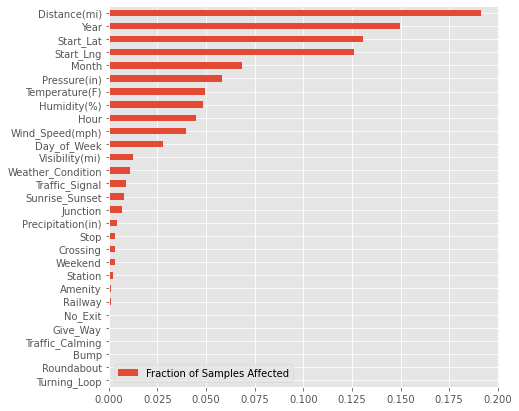

In [79]:
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', figsize=(7,7))

## Let's try removing the outliers from the numerical columns to see if our scores improve
- numerical columns = ['Distance(mi)', 'Temperature(F)', 'Visibility(mi)', 'Wind_Speed(mph)']
- Distance max = 227.21 mi
- Temp max = 127.4 F (this is okay)
- Visibility max = 140 mi
- Wind Speed max = 822.8 mph


In [34]:
pd.set_option('display.max_columns', None)
df.describe()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Hour,Day_of_Week,Month,Year,Weekend
count,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.0,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000,800427.000000
mean,2.290555,35.532484,-119.486306,0.110388,64.973985,59.572757,29.794128,9.149454,7.201091,0.002962,0.550819,0.006425,0.000216,0.032059,0.000795,0.135300,0.000422,0.010813,0.000022,0.019392,0.017773,0.000292,0.081322,0.0,0.321341,12.510576,2.644367,6.445458,2018.102427,0.916432
std,0.490828,2.035670,1.952353,0.623116,12.498112,23.429945,0.566702,2.357273,5.399943,0.034612,0.659839,0.079900,0.014700,0.176157,0.028177,0.342044,0.020545,0.103422,0.004742,0.137899,0.132126,0.017096,0.273329,0.0,0.466992,5.603003,1.838686,3.466271,1.370322,0.276739
min,1.000000,32.542587,-124.369232,0.000000,-29.900000,1.000000,0.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,2016.000000,0.000000
25%,2.000000,33.956570,-121.648949,0.000000,56.000000,42.000000,29.800000,10.000000,4.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,8.000000,1.000000,3.000000,2017.000000,1.000000
50%,2.000000,34.164516,-118.387817,0.000000,64.000000,62.000000,29.920000,10.000000,7.202019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,13.000000,3.000000,6.000000,2018.000000,1.000000
75%,3.000000,37.698586,-117.916377,0.010000,73.000000,78.000000,30.030000,10.000000,9.200000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,17.000000,4.000000,10.000000,2019.000000,1.000000
max,4.000000,42.005420,-114.300598,227.210007,127.400000,100.000000,33.040000,140.000000,822.800000,24.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,23.000000,6.000000,12.000000,2020.000000,1.000000


In [35]:
q = df['Visibility(mi)'].quantile(0.99)
#99th_q_dist = 1.62
#99th_q_temp = 97.0
#99th_q_visib = 10.0
#99th_q_windspeed = 21.0

df2 = df[df['Distance(mi)'] < 1.62]
df3 = df2[df2['Visibility(mi)'] < 11.0]
cldf = df3[df3['Wind_Speed(mph)'] < 21.0]
#cldf = cleaned dataset with no outliers

In [36]:
cldf.describe()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Hour,Day_of_Week,Month,Year,Weekend
count,783366.00000,783366.000000,783366.000000,783366.000000,783366.000000,783366.000000,783366.000000,783366.000000,783366.000000,783366.000000,783366.000000,783366.000000,783366.000000,783366.000000,783366.00000,783366.000000,783366.000000,783366.000000,783366.000000,783366.000000,783366.000000,783366.000000,783366.000000,783366.0,783366.000000,783366.000000,783366.000000,783366.000000,783366.000000,783366.000000
mean,2.28778,35.515457,-119.472040,0.076366,64.984720,59.702074,29.797879,9.122234,6.992729,0.002900,0.549447,0.006426,0.000213,0.032217,0.00080,0.135324,0.000425,0.010851,0.000023,0.019619,0.017763,0.000291,0.082024,0.0,0.322799,12.493463,2.639938,6.455227,2018.099245,0.917089
std,0.48661,2.031948,1.947995,0.214180,12.492698,23.360476,0.557860,2.057385,4.105135,0.034635,0.658922,0.079905,0.014599,0.176577,0.02828,0.342069,0.020613,0.103600,0.004793,0.138688,0.132089,0.017058,0.274402,0.0,0.467547,5.610765,1.837802,3.467901,1.371101,0.275748
min,1.00000,32.542587,-124.369232,0.000000,-29.900000,1.000000,0.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,2016.000000,0.000000
25%,2.00000,33.949795,-121.626007,0.000000,56.000000,42.000000,29.800000,10.000000,4.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,8.000000,1.000000,3.000000,2017.000000,1.000000
50%,2.00000,34.156834,-118.378090,0.000000,64.000000,62.000000,29.920000,10.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,13.000000,3.000000,6.000000,2018.000000,1.000000
75%,3.00000,37.692471,-117.913528,0.010000,73.000000,78.000000,30.030000,10.000000,9.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,17.000000,4.000000,10.000000,2019.000000,1.000000
max,4.00000,42.005420,-114.300598,1.619000,127.400000,100.000000,33.040000,10.500000,20.700000,24.000000,2.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,23.000000,6.000000,12.000000,2020.000000,1.000000


In [37]:
# cldf.to_csv('final_no_outliers_CA_data.csv')

In [38]:
for i in cldf['Severity'].unique():
    print('Severity', i, 
          cldf[cldf['Severity'] == i]['Start_Lat'].count())

Severity 3 217164
Severity 2 553736
Severity 1 5553
Severity 4 6913


## Run Logististic Reg, Decision Tree, and RF Classifiers using stratified train/test sets

In [39]:
cols = cldf.columns.tolist()

y_col = 'Severity'
X_col = cols
X_col.remove('Severity')
X_col.remove('Description')
X_col.remove('Street')
X_col.remove('City')
X_col.remove('County')
# X_col.remove('Weather_Condition')
X_col.remove('Date')
#Removed columns that have string values. Will need to get_dummies or convert to_numeric in order to use them

X = cldf[X_col]
y = cldf[y_col]

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,
                                                    random_state=462, stratify=y, test_size=0.4)

In [40]:
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
 
# Predict on training set
lr_pred = lr.predict(X_test)

# Checking accuracy
print('Accuracy Score:', accuracy_score(y_test, lr_pred))

# Checking unique values
predictions = pd.DataFrame(lr_pred)
print('Prediction value counts:', predictions[0].value_counts())
# f1 score
print('F1 Score:', f1_score(y_test, lr_pred, average='macro'))

# recall score
print('Recall Score:', recall_score(y_test, lr_pred, average='macro'))

Accuracy Score: 0.7083233603640692
Prediction value counts: 2    310070
3      3277
Name: 0, dtype: int64
F1 Score: 0.2172603556451101
Recall Score: 0.2537386485241202


In [41]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)

print("Accuracy = {:.3f}".format(accuracy_score(y_test, clf_pred)))

print("My prediction: {}".format(clf_pred[0:20]))
print("Actual result: {}".format(y_test[0:20]))

predictions = pd.DataFrame(clf_pred)
print('Prediction value counts:', predictions[0].value_counts())
# f1 score
print('F1 Score:', f1_score(y_test, clf_pred, average='macro'))

# recall score
print('Recall Score:', recall_score(y_test, clf_pred, average='macro'))

Accuracy = 0.845
My prediction: [2 2 2 2 3 3 2 3 3 3 2 3 2 2 2 3 2 2 3 3]
Actual result: [2 3 2 2 3 3 2 2 3 3 2 3 2 2 2 3 2 2 3 3]
Prediction value counts: 2    219185
3     88240
4      3234
1      2688
Name: 0, dtype: int64
F1 Score: 0.629893736206245
Recall Score: 0.6515708864422903


In [42]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=50,
                           max_features='auto',
                           random_state=0)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
# print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

# f1 score
print("F1 score:", f1_score(y_test, pred, average='macro'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='macro'))

accuracy = 0.8508745895125851
F1 score: 0.6628905512290776
Recall score: 0.5972606331883035


In [43]:
confusion_matrix(y_test, pred, labels=[1,2,3,4])

array([[  1146,   1027,     46,      2],
       [   300, 206007,  15124,     64],
       [    39,  28030,  58728,     69],
       [     4,   1631,    392,    738]])

In [44]:
multilabel_confusion_matrix(y_test, pred, labels=[1,2,3,4])

array([[[310783,    343],
        [  1075,   1146]],

       [[ 61164,  30688],
        [ 15488, 206007]],

       [[210919,  15562],
        [ 28138,  58728]],

       [[310447,    135],
        [  2027,    738]]])

## Let's generate synthetic samples to balance the dataset based on `Severity`
- imlearn's SMOTE - Synthetic Minority Oversampling Technique

In [45]:
from imblearn.over_sampling import SMOTE

In [46]:
cols = cldf.columns.tolist()

y_col = 'Severity'
X_col = cols
X_col.remove('Severity')
X_col.remove('Description')
X_col.remove('Street')
X_col.remove('City')
X_col.remove('County')
# X_col.remove('Weather_Condition')
X_col.remove('Date')
#Removed columns that have string values. Will need to get_dummies or convert to_numeric in order to use them

X = cldf[X_col]
y = cldf[y_col]

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,
                                                    random_state=462, stratify=y, test_size=0.4)

In [47]:
#set up test and train sets first, which we already have
sm = SMOTE(random_state=462)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [48]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)

print("My prediction: {}".format(clf_pred[0:20]))
print("Actual result: {}".format(y_test[0:20]))

predictions = pd.DataFrame(clf_pred)
print('Prediction value counts:', predictions[0].value_counts())

# accuracy score
print("Accuracy = {:.3f}".format(accuracy_score(y_test, clf_pred)))

# f1 score
print('F1 Score:', f1_score(y_test, clf_pred, average='macro'))

# recall score
print('Recall Score:', recall_score(y_test, clf_pred, average='macro'))

My prediction: [2 2 2 2 3 3 2 3 3 3 2 3 2 2 2 3 3 2 2 3]
Actual result: [2 3 2 2 3 3 2 2 3 3 2 3 2 2 2 3 2 2 3 3]
Prediction value counts: 2    210469
3     95320
4      3856
1      3702
Name: 0, dtype: int64
Accuracy = 0.817
F1 Score: 0.58422482897408
Recall Score: 0.6400773326844089


In [49]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=50,
                           max_features='auto',
                           random_state=0)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
# print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

# f1 score
print("F1 score:", f1_score(y_test, pred, average='macro'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='macro'))

accuracy = 0.8316818096231973
F1 score: 0.6449468042365434
Recall score: 0.6273438414602518


## Under/Over Sampling the Severity levels
- Set the quantity of each severity level to 100,000 each

In [69]:
# df1 = df.drop(['Severity'], axis = 1)
df_bl = pd.concat([df[df['Severity']==1].sample(100000, replace = True),
                    df[df['Severity']==2].sample(100000),
                    df[df['Severity']==3].sample(100000),
                    df[df['Severity']==4].sample(100000, replace = True)], axis=0)
print('resampled data:', df_bl.Severity.value_counts())

resampled data: 4    100000
3    100000
2    100000
1    100000
Name: Severity, dtype: int64


In [70]:
df_bl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 593931 to 770099
Data columns (total 35 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Severity           400000 non-null  int64  
 1   Start_Lat          400000 non-null  float64
 2   Start_Lng          400000 non-null  float64
 3   Distance(mi)       400000 non-null  float64
 4   Description        400000 non-null  object 
 5   Street             400000 non-null  object 
 6   City               400000 non-null  object 
 7   County             400000 non-null  object 
 8   Temperature(F)     400000 non-null  float64
 9   Humidity(%)        400000 non-null  float64
 10  Pressure(in)       400000 non-null  float64
 11  Visibility(mi)     400000 non-null  float64
 12  Wind_Speed(mph)    400000 non-null  float64
 13  Precipitation(in)  400000 non-null  float64
 14  Weather_Condition  400000 non-null  int64  
 15  Amenity            400000 non-null  int64  
 1

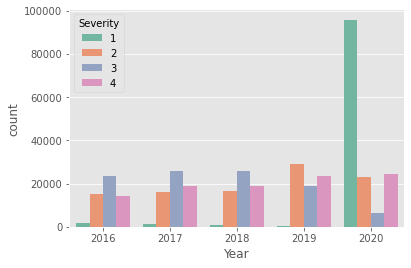

In [71]:
sns.countplot(x='Year', hue='Severity', data=df_bl, palette="Set2")

In [59]:
df.groupby('Year')['Severity'].value_counts()

Year  Severity
2016  2            85602
      3            51348
      4             1182
      1               96
2017  2            91464
      3            56870
      4             1562
      1               85
2018  2            95023
      3            57236
      4             1552
      1               39
2019  2           164393
      3            41975
      4             1928
      1               18
2020  2           128274
      3            14323
      1             5436
      4             2021
Name: Severity, dtype: int64

In [72]:
cols = cldf.columns.tolist()

y_col = 'Severity'
X_col = cols
X_col.remove('Severity')
X_col.remove('Description')
X_col.remove('Street')
X_col.remove('City')
X_col.remove('County')
# X_col.remove('Weather_Condition')
X_col.remove('Date')
#Removed columns that have string values. Will need to get_dummies or convert to_numeric in order to use them

X = df_bl[X_col]
y = df_bl[y_col]

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,
                                                    random_state=462, stratify=y)

My prediction: [2 2 1 4 1 2 2 2 2 3 1 3 1 2 4 1 2 4 2 4]
Actual result: [2 3 1 4 1 2 2 3 3 3 1 3 1 2 4 1 2 4 3 4]
Prediction value counts: 4    26377
1    25516
3    24635
2    23472
Name: 0, dtype: int64
Accuracy = 0.887
F1 Score: 0.885492518036469
Recall Score: 0.8873


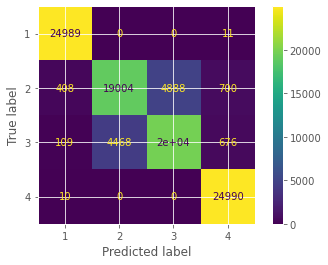

In [74]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf_pred = clf.predict(X_test)

print("My prediction: {}".format(clf_pred[0:20]))
print("Actual result: {}".format(y_test[0:20]))

predictions = pd.DataFrame(clf_pred)
print('Prediction value counts:', predictions[0].value_counts())

# accuracy score
print("Accuracy = {:.3f}".format(accuracy_score(y_test, clf_pred)))

# f1 score
print('F1 Score:', f1_score(y_test, clf_pred, average='macro'))

# recall score
print('Recall Score:', recall_score(y_test, clf_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test)
plt.show()

accuracy = 0.88847
F1 score: 0.8869938787737279
Recall score: 0.88847


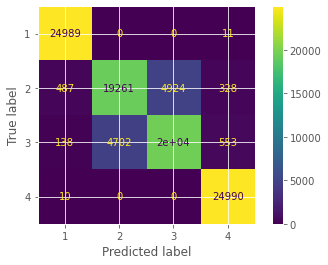

In [75]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=50,
                           max_features='auto',
                           random_state=0)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
# print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

# f1 score
print("F1 score:", f1_score(y_test, pred, average='macro'))

# recall score
print("Recall score:", recall_score(y_test, pred, average='macro'))

plot_confusion_matrix(rf, X_test, y_test)
plt.show()

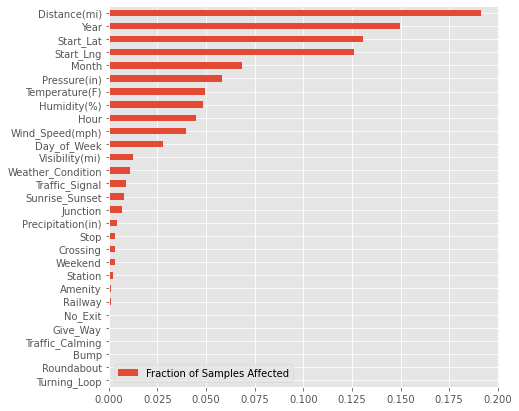

In [78]:
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', figsize=(7,7))

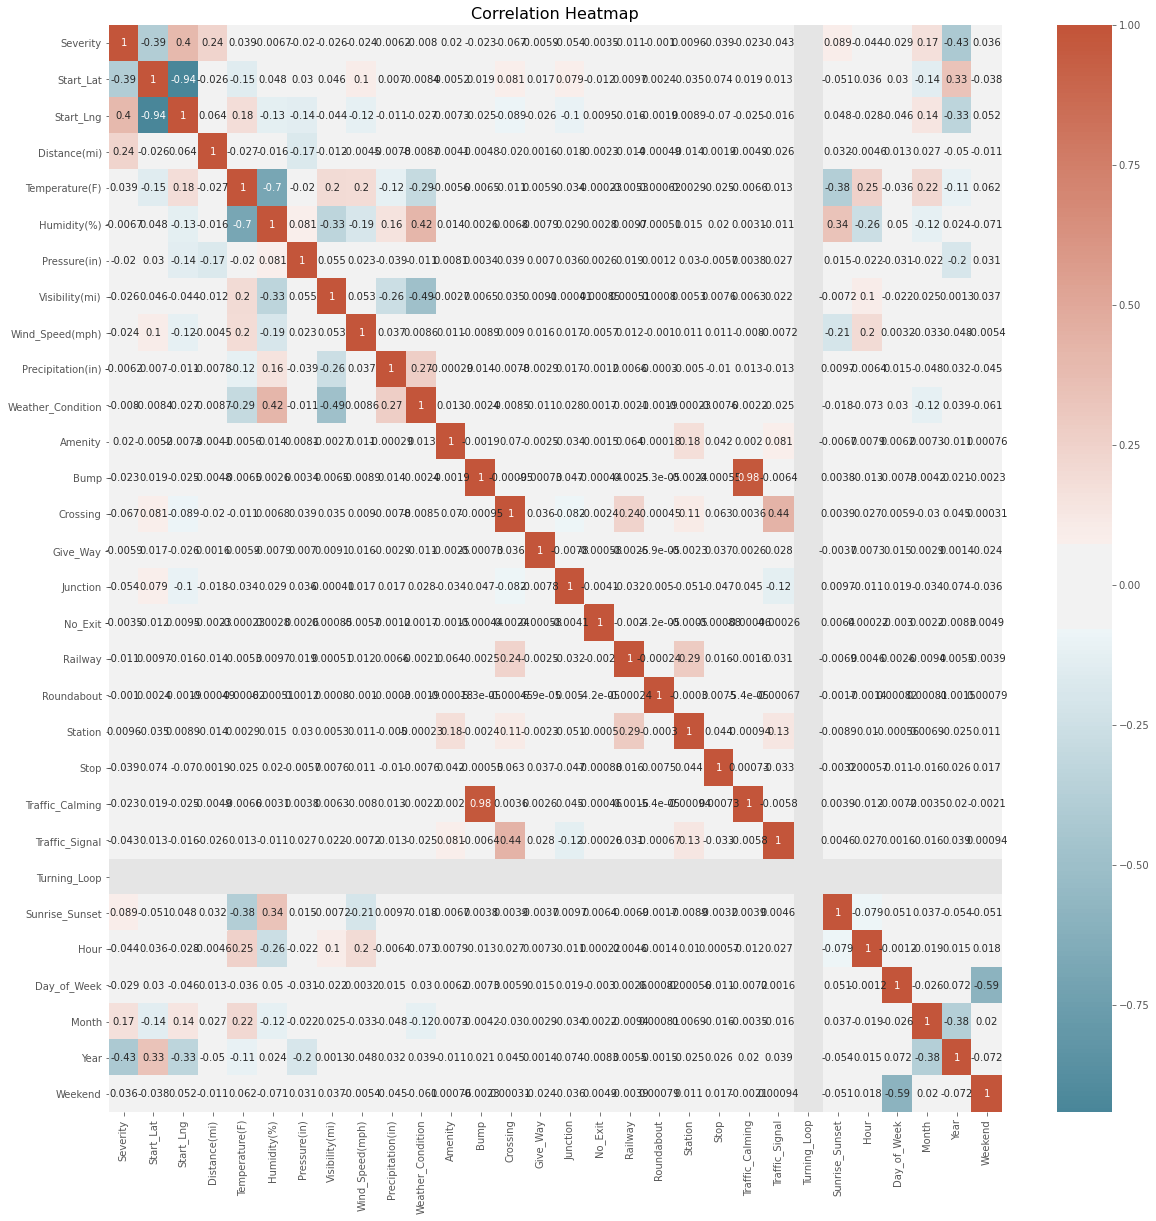

In [82]:
plt.figure(figsize=(20,20))
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(df_bl.corr(), annot=True,cmap=cmap, center=0).set_title("Correlation Heatmap", fontsize=16)
plt.show()